In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import yfinance as yf

### Prepare data

In [2]:
# we will look at weekly data from the last 3 years
start_date = '2024-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

tickers = ['SHOP.TO', 'COST', 'GME']
dfs = {}

for ticker in tickers:
    dfs[ticker] = yf.download(ticker, start=start_date, end=end_date, interval='1d').dropna()
    # convert index to datetime
    dfs[ticker].index = pd.DatetimeIndex(dfs[ticker].index)
    # infer frequency (doesnt really work for daily data since markets are closed during 2 days of the week)
    # dfs[ticker] = dfs[ticker].asfreq(pd.infer_freq(dfs[ticker].index)) 

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Check for stationarity: graphically and analytically

In [3]:
# time series plot function
def plot_prices(dfs: dict, plot_columns: list, plot_labels: list, title: str, mean=False, ylabel='Price ($)') -> None:
    fig, axs = plt.subplots(len(dfs), 1, figsize=(12, 3*len(dfs)))
    
    for i, (ticker, df) in enumerate(dfs.items()):
        for column, label in zip(plot_columns, plot_labels):
            axs[i].plot(df[column], label=label)
            # plot mean of dataset
            if mean:
                axs[i].axhline(df[column].mean(), color='r', linestyle='--', label=f'Mean')
                
        axs[i].set_ylabel(ylabel)
        axs[i].set_title(ticker)
        axs[i].legend()
        axs[i].grid()
        
    axs[-1].set_xlabel('Date')
    
    fig.suptitle(title)
    fig.tight_layout()

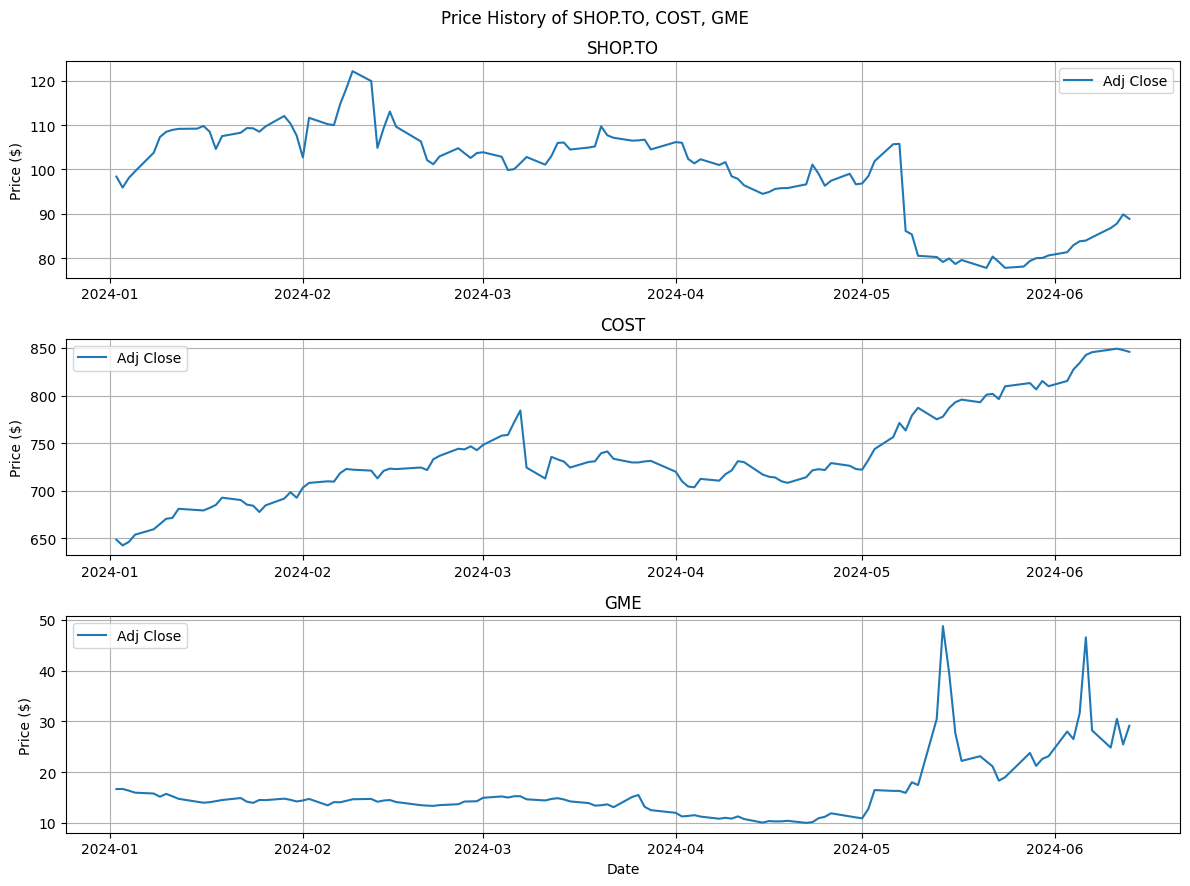

In [4]:
plot_prices(
    dfs, 
    ['Adj Close'], 
    [f'Adj Close'],
    f'Price History of {", ".join(dfs.keys())}'
)

In [5]:
# AD Fuller Test
def adfuller_test(dfs: dict, column: str) -> None:
    for ticker, df in dfs.items():
        result = adfuller(df[column])
        print(f'{ticker}:')
        print(f'ADF Test Statistic: {np.round(result[0], 4)}')
        print(f'p-value: {np.round(result[1], 4)}')
        print(f'Critical Values: {result[4]} \n')

In [6]:
# ADF of the closing price
adfuller_test(dfs, 'Adj Close')

SHOP.TO:
ADF Test Statistic: -1.4513
p-value: 0.5574
Critical Values: {'1%': -3.489057523907491, '5%': -2.887246327182993, '10%': -2.5804808802708528} 

COST:
ADF Test Statistic: -0.2864
p-value: 0.9274
Critical Values: {'1%': -3.490683082754047, '5%': -2.8879516565798817, '10%': -2.5808574442009578} 

GME:
ADF Test Statistic: -0.3238
p-value: 0.9221
Critical Values: {'1%': -3.4954932834550623, '5%': -2.8900369024285117, '10%': -2.5819706975209726} 



In [7]:
# take first difference
for ticker in dfs.keys():
    dfs[ticker]['diff'] = dfs[ticker]['Adj Close'].diff()
    dfs[ticker] = dfs[ticker].dropna()

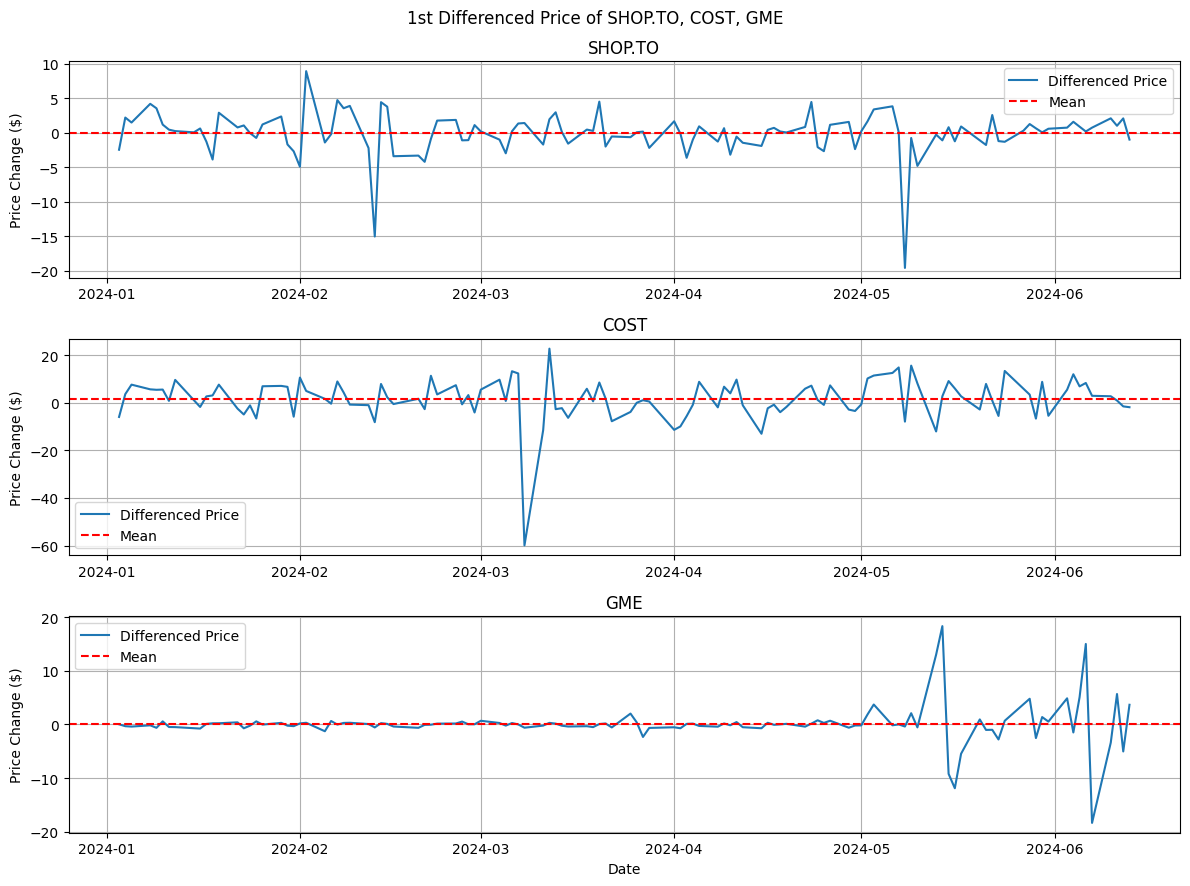

In [8]:
# plot first difference    
plot_prices(
    dfs, 
    ['diff'], 
    ['Differenced Price'],
    f'1st Differenced Price of {", ".join(dfs.keys())}',
    True,
    'Price Change ($)'
)

In [9]:
# ADF of the first difference
adfuller_test(dfs, 'diff')

SHOP.TO:
ADF Test Statistic: -8.339
p-value: 0.0
Critical Values: {'1%': -3.4901313156261384, '5%': -2.8877122815688776, '10%': -2.5807296460459184} 

COST:
ADF Test Statistic: -9.3781
p-value: 0.0
Critical Values: {'1%': -3.490683082754047, '5%': -2.8879516565798817, '10%': -2.5808574442009578} 

GME:
ADF Test Statistic: -4.8081
p-value: 0.0001
Critical Values: {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097} 



### ACF and PACF plots

In [10]:
# ACF, PACF plots
def plot_corr(dfs: dict, plot_column: str, title: str, type: str) -> None:
    fig, axs = plt.subplots(len(dfs), 1, figsize=(12, 3*len(dfs)))
    
    for i, (ticker, df) in enumerate(dfs.items()):
        if type == 'ACF':
            plot_acf(df[plot_column], title=f'{ticker}', ax=axs[i])
        elif type == 'PACF':
            plot_pacf(df[plot_column], title=f'{ticker}', ax=axs[i])
    
    fig.suptitle(title)
    fig.tight_layout()

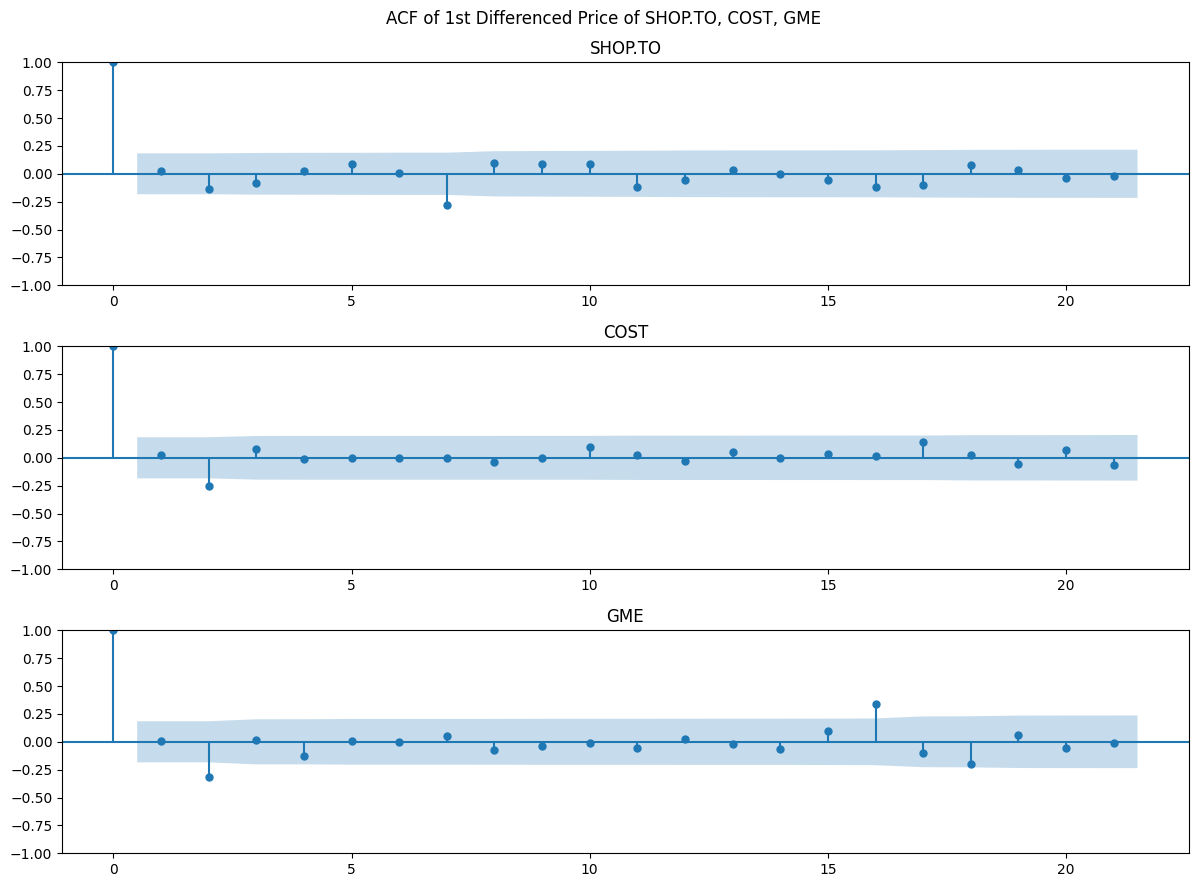

In [11]:
# ACF of 1st differenced price
plot_corr(
    dfs,
    'diff',
    f'ACF of 1st Differenced Price of {", ".join(dfs.keys())}',
    'ACF'
)

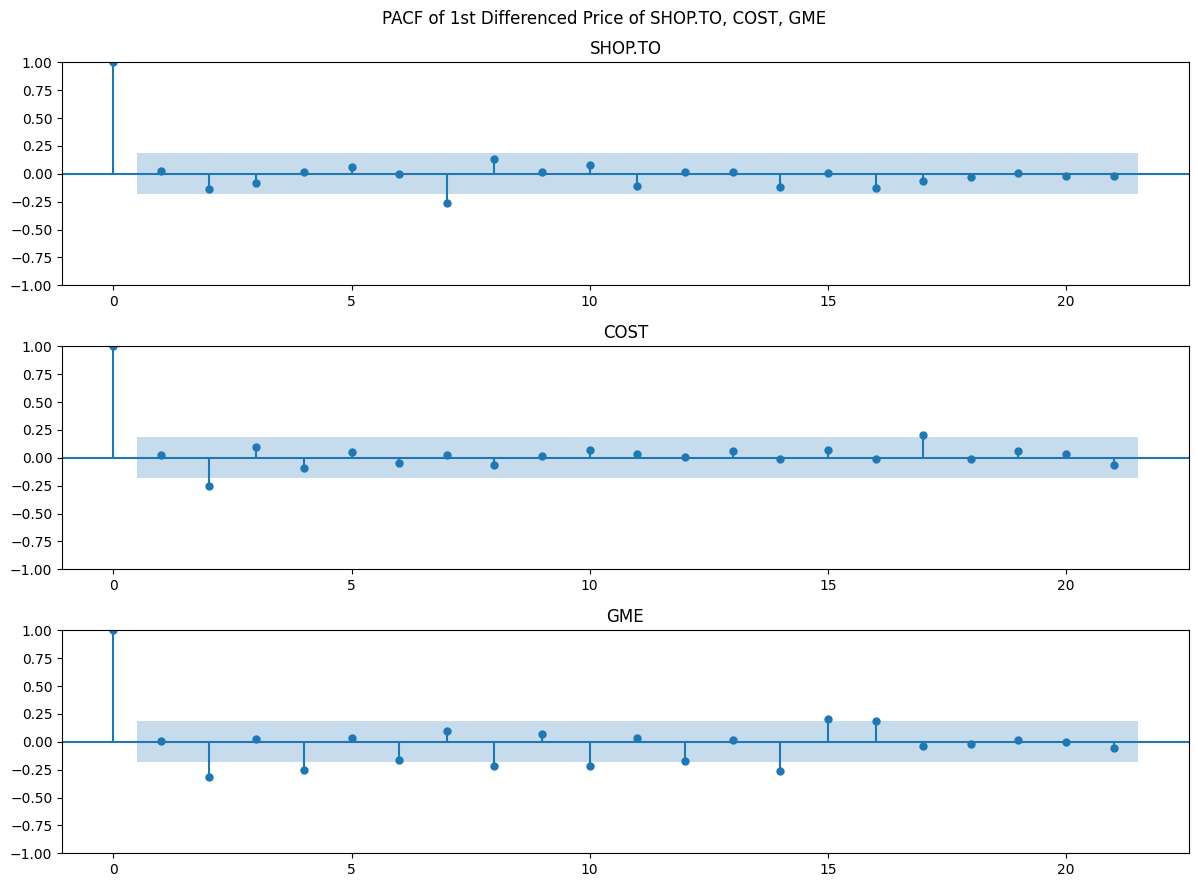

In [12]:
# PACF of 1st differenced price
plot_corr(
    dfs,
    'diff',
    f'PACF of 1st Differenced Price of {", ".join(dfs.keys())}',
    'PACF'
)

### Using AIC and BIC to find best models

In [13]:
# preparing data...
split = 0.7

train_data, test_data = {}, {}

for ticker in tickers:
    train_data[ticker] = pd.DataFrame(
        data={'price': dfs[ticker]['Adj Close'][:int(len(dfs[ticker])*split)]},
        index=dfs[ticker].index[:int(len(dfs[ticker])*split)]
    )
    
    test_data[ticker] = pd.DataFrame(
        data={'price': dfs[ticker]['Adj Close'][int(len(dfs[ticker])*split):]},
        index=dfs[ticker].index[int(len(dfs[ticker])*split):]
    )

In [14]:
# generate candidate model orders
AR = [0, 1, 2, 3, 4, 5]
I = [0, 1, 2]
MA = [0, 1, 2, 3, 4, 5]

model_orders = []
for p in AR:
    for i in I:
        for q in MA:
            model_orders.append((p, i, q))

In [15]:
len(model_orders)

108

In [16]:
models2 = {}
aic = {}
bic = {}

for ticker, df in train_data.items():
    for order in model_orders:
        model = ARIMA(df, order=order)
        fit = model.fit()
        
        models2.setdefault(ticker, []).append(fit)
        aic.setdefault(ticker, []).append(fit.aic)
        bic.setdefault(ticker, []).append(fit.bic)

c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it ha

In [17]:
# min AIC and BIC models
min_aics = {}
min_bics = {}

for ticker in tickers:
    min_aics[ticker] = {
        'value': min(aic[ticker]),
        'index': aic[ticker].index(min(aic[ticker]))
    }
    
    min_bics[ticker] = {
        'value': min(bic[ticker]),
        'index': bic[ticker].index(min(bic[ticker]))
    }


In [18]:
print(f'Min AIC: {min_aics}')
print(f'Min BIC: {min_bics}')

Min AIC: {'SHOP.TO': {'value': 389.19589681504266, 'index': 44}, 'COST': {'value': 567.7102575397313, 'index': 15}, 'GME': {'value': 125.25573090100194, 'index': 8}}
Min BIC: {'SHOP.TO': {'value': 394.48097150599216, 'index': 6}, 'COST': {'value': 575.5408565921718, 'index': 6}, 'GME': {'value': 128.184664244214, 'index': 6}}


In [19]:
# model orders with min AIC
optimal_orders = {}
for ticker in tickers:
    optimal_orders[ticker] = {
        'Min AIC Model': model_orders[min_aics[ticker]['index']],
        # 'Min BIC Model': model_orders[min_bics[ticker]['index']]
    }

In [20]:
print(f'Optimal Arima Orders: {optimal_orders}')

Optimal Arima Orders: {'SHOP.TO': {'Min AIC Model': (2, 1, 2)}, 'COST': {'Min AIC Model': (0, 2, 3)}, 'GME': {'Min AIC Model': (0, 1, 2)}}


In [21]:
# predictions plot
for ticker in tickers:
    train_data[ticker]['prediction'] = np.array(models2[ticker][min_aics[ticker]['index']].predict().values)
    
    # drop first few rows
    train_data[ticker] = train_data[ticker].iloc[3:]

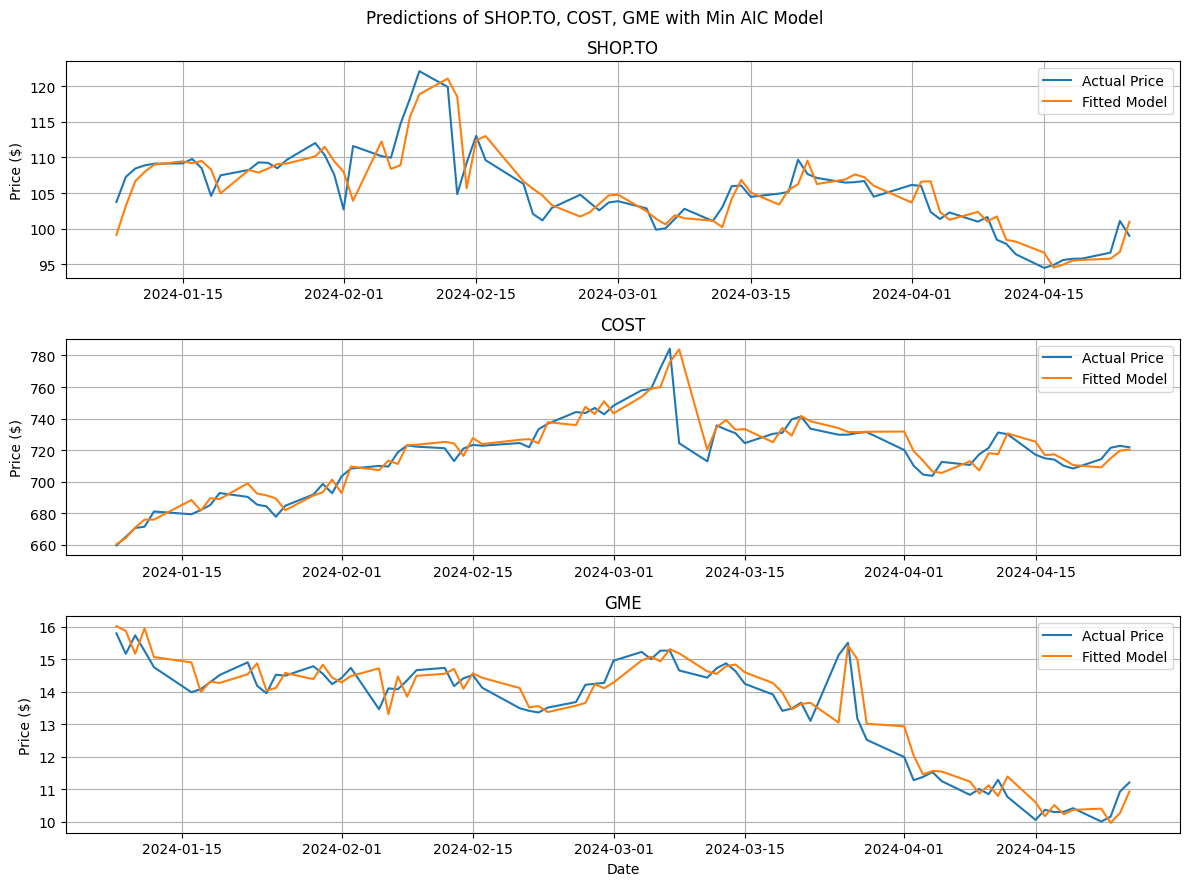

In [22]:
plot_prices(
    train_data,
    ['price', 'prediction'],
    ['Actual Price', 'Fitted Model'],
    f'Predictions of {", ".join(dfs.keys())} with Min AIC Model'
)

### Alternative: Use autoarima to find optimal model

In [23]:
auto_models = {}

for ticker in tickers:
    auto_models[ticker] = auto_arima(train_data[ticker]['price'], start_p=0, start_q=0, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=379.278, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=381.141, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=380.937, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=377.312, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.158 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=554.454, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=556.407, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=556.332, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=553.024, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=554.351, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.101 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=124.043, Time=0.01 sec
 ARIMA

huh

### Rolling Forecasts

In [24]:
for ticker in tickers:
    ticker_forecasts = []
    
    for i, date in enumerate(test_data[ticker].index):
        # update training data with new data point
        new_train_data = pd.concat([train_data[ticker]['price'], test_data[ticker]['price'].iloc[:i]])
        model = ARIMA(new_train_data, order=optimal_orders[ticker]['Min AIC Model'])
        model_fit = model.fit()
        forecast = model_fit.forecast()
        ticker_forecasts.append(float(forecast))
    
    test_data[ticker]['forecasts'] = ticker_forecasts
        

c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Predicti

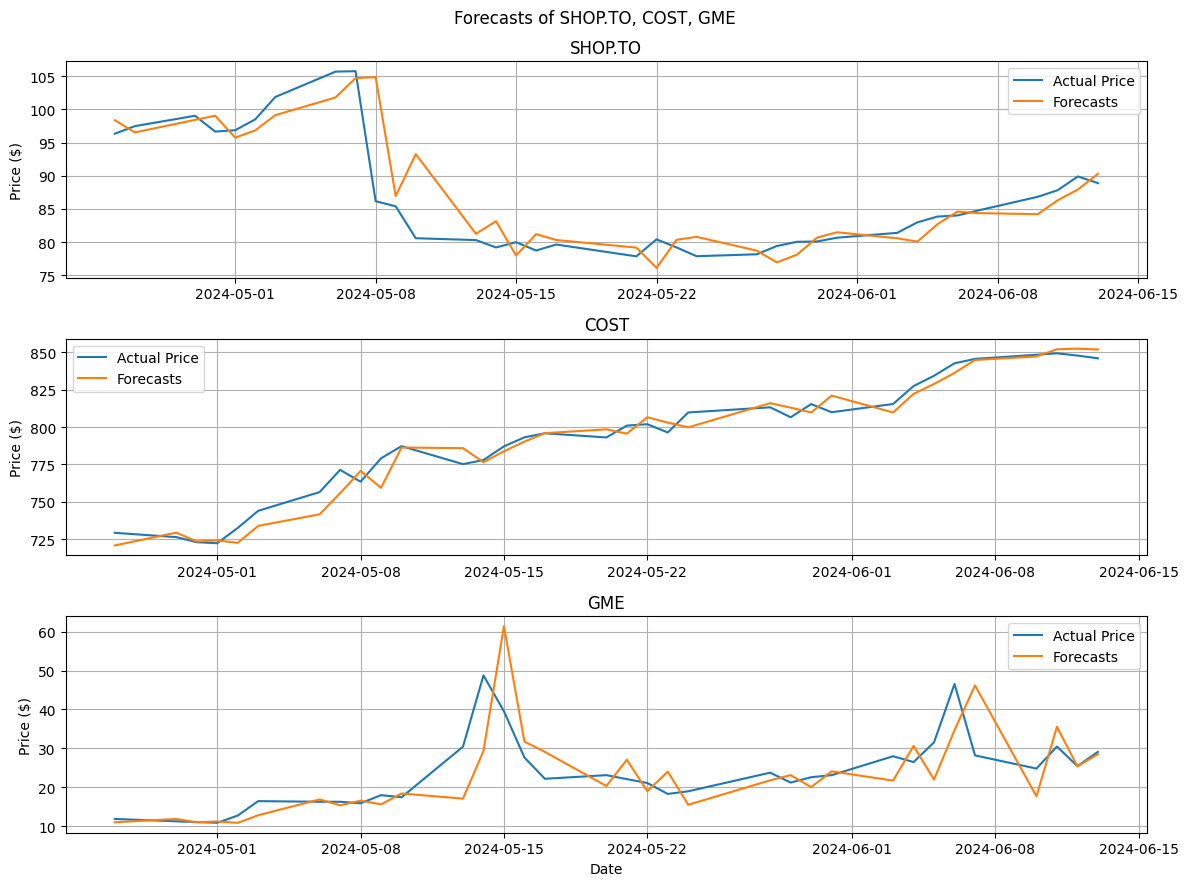

In [25]:
plot_prices(
    test_data,
    ['price', 'forecasts'],
    ['Actual Price', 'Forecasts'],
    f'Forecasts of {", ".join(dfs.keys())}'
)

### Forecast Evaluation

In [26]:
# residuals
for ticker in tickers:
    test_data[ticker]['residuals'] = test_data[ticker]['price'] - test_data[ticker]['forecasts']

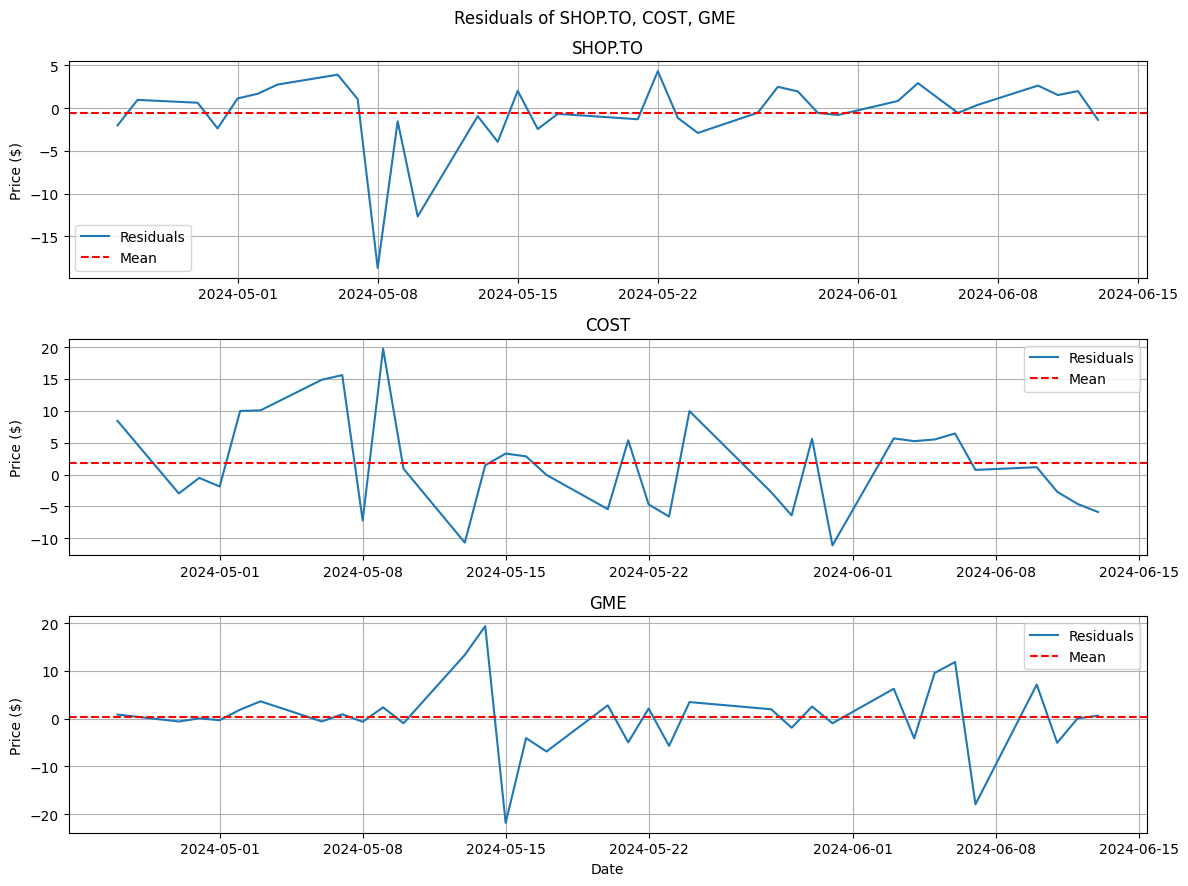

In [27]:
plot_prices(
    test_data,
    ['residuals'],
    ['Residuals'],
    f'Residuals of {", ".join(dfs.keys())}',
    True
)

In [28]:
# Mean absolute percent error
print(f'Mean Absolute Error:')

for ticker in tickers:
    mae = np.mean(np.abs(test_data[ticker]['residuals']/test_data[ticker]['price']))
    
    print(f'{ticker}: {np.round(mae, 4)*100}%')

Mean Absolute Error:
SHOP.TO: 2.97%
COST: 0.77%
GME: 17.68%


In [29]:
# root mean squared error
print(f'Root Mean Squared Error:')

for ticker in tickers:
    rmse = np.sqrt(np.mean(test_data[ticker]['residuals']**2))
    
    print(f'{ticker}: {np.round(rmse, 4)}')

Root Mean Squared Error:
SHOP.TO: 4.2941
COST: 7.5747
GME: 7.4863
